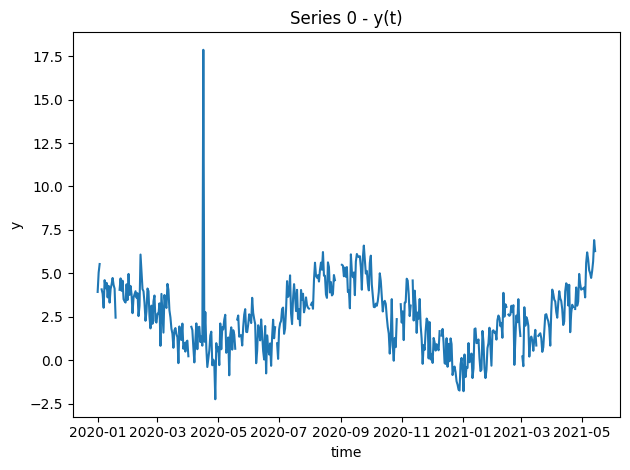

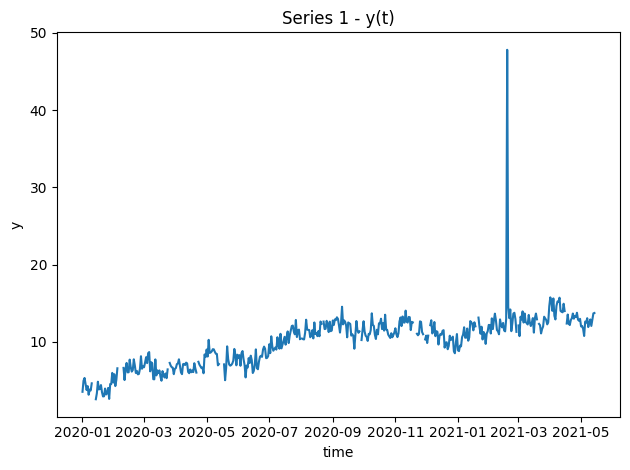

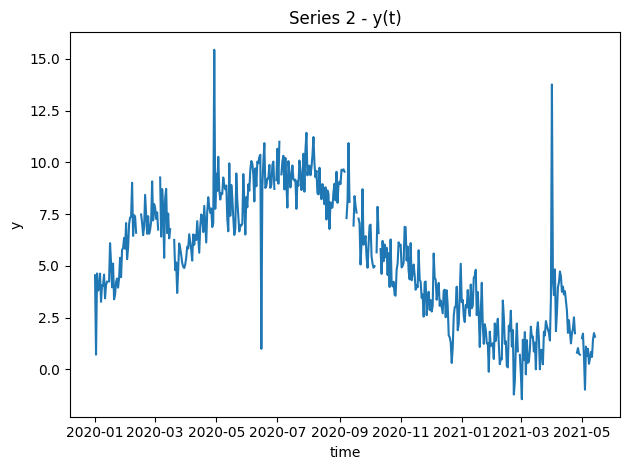

In [1]:
# Time Series Pedagogical Generator
# ---------------------------------
# This cell defines a *self-contained* synthetic time series generator aimed at teaching.
# It supports many knobs (trend, seasonality, ARMA noise, regime switches, outliers,
# missingness, exogenous variables, multivariate correlation, calendar effects, etc.).
#
# At the end, we create an example dataset, show a quick plot, and save a CSV you can download.
#
# Usage (basic):
#   gen = TimeSeriesGenerator(random_state=42)
#   df, meta = gen.make(
#       n_series=3, n_steps=400, freq='D',
#       trend={"type": "piecewise", "knots": [120, 260], "slopes": [0.02, -0.01, 0.03]},
#       seasonality=[{"period": 7, "amplitude": 3.0}, {"period": 30.5, "amplitude": 2.0}],
#       noise={"ar": [0.6], "ma": [0.2], "sigma": 1.0},
#       regime={"n_states": 2, "p": [[0.95, 0.05],[0.08,0.92]], "state_bias": [0.0, 2.5], "state_sigma_scale": [1.0, 1.8]},
#       outliers={"prob": 0.01, "scale": 6.0},
#       missing={"prob": 0.03, "block_prob": 0.02, "block_max": 7},
#       heterosked={"type": "arch1", "alpha0": 0.2, "alpha1": 0.6},
#       exog={"n_features": 2, "types": ["random_walk", "seasonal"], "beta": [0.5, -1.0]},
#       multivariate={"n_factors": 2, "mix_strength": 0.8}
#   )
#
# The returned `df` is a tidy DataFrame with columns: ["series", "time", "y", ...exog..., ...calendar features...].
# The `meta` dict contains the ground-truth components, parameters, and latent states for teaching.
#
# Plot helpers:
#   gen.plot_series(df, series_id=0)                 # y over time
#   gen.plot_decompose(meta, series_id=0)            # trend / seasonality / noise
#
# A CSV is saved at the end for convenience.

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi


def _poly_trend(n: int, coeffs: List[float]) -> np.ndarray:
    t = np.arange(n)
    y = np.zeros(n, dtype=float)
    for k, c in enumerate(coeffs):
        y += c * t**k
    return y


def _piecewise_linear_trend(n: int, knots: List[int], slopes: List[float], intercept: float = 0.0) -> np.ndarray:
    """
    Piecewise-linear trend with slopes per segment.
    knots: sorted list of change indices (0 < k < n). Length m.
    slopes: length m+1, slope per segment.
    """
    t = np.arange(n)
    segments = [0] + knots + [n]
    y = np.zeros(n, dtype=float)
    current = intercept
    for i in range(len(segments)-1):
        start, end = segments[i], segments[i+1]
        seg_len = end - start
        # linear ramp for this segment
        local_t = np.arange(seg_len)
        y[start:end] = current + slopes[i] * local_t
        # update intercept for next segment
        current = y[end-1] + slopes[i]
    return y


def _seasonal_component(n: int, period: float, amplitude: float, phase: float = 0.0, harmonics: int = 1) -> np.ndarray:
    t = np.arange(n)
    y = np.zeros(n, dtype=float)
    for h in range(1, harmonics+1):
        y += (amplitude / h) * np.sin(2 * np.pi * h * (t + phase) / period)
    return y


def _arma_innovations(n: int, ar: List[float], ma: List[float], sigma: float, rng: np.random.Generator) -> np.ndarray:
    """Generate ARMA errors via recursion + filtering (teaching-friendly, not optimized)."""
    p, q = len(ar), len(ma)
    e = rng.normal(0.0, sigma, size=n + 200)  # burn-in for stability
    y = np.zeros_like(e)
    for t in range(max(p, q), len(e)):
        ar_part = 0.0
        for i in range(p):
            ar_part += ar[i] * y[t-1-i]
        ma_part = 0.0
        for j in range(q):
            ma_part += ma[j] * e[t-1-j]
        y[t] = ar_part + e[t] + ma_part
    return y[-n:]


def _arch1_scale(e_prev2: float, alpha0: float, alpha1: float) -> float:
    # variance_t = alpha0 + alpha1 * e_{t-1}^2
    return max(alpha0 + alpha1 * e_prev2, 1e-8)


def _markov_chain(n: int, P: np.ndarray, pi0: Optional[np.ndarray], rng: np.random.Generator) -> np.ndarray:
    """Sample a Markov chain of length n with transition matrix P and initial probs pi0."""
    k = P.shape[0]
    if pi0 is None:
        # stationary approx by left eigenvector for teaching simplicity
        w, v = np.linalg.eig(P.T)
        i = np.argmin(np.abs(w - 1.0))
        pi0 = np.real(v[:, i])
        pi0 = np.maximum(pi0, 0)
        pi0 = pi0 / pi0.sum()
    s = np.zeros(n, dtype=int)
    s[0] = rng.choice(k, p=pi0)
    for t in range(1, n):
        s[t] = rng.choice(k, p=P[s[t-1]])
    return s


@dataclass
class TimeSeriesGenerator:
    random_state: Optional[int] = None
    _rng: np.random.Generator = field(init=False, repr=False)

    def __post_init__(self):
        self._rng = np.random.default_rng(self.random_state)

    # ------------------------------
    # Main interface
    # ------------------------------
    def make(
        self,
        n_series: int = 1,
        n_steps: int = 500,
        freq: str = "D",
        start: Union[str, pd.Timestamp, None] = None,
        # Trend
        trend: Optional[Dict[str, Any]] = None,
        # Seasonality: list of dicts
        seasonality: Optional[List[Dict[str, Any]]] = None,
        # Low-frequency cycle
        cycle: Optional[Dict[str, Any]] = None,
        # Noise (ARMA)
        noise: Optional[Dict[str, Any]] = None,
        # Regime switching
        regime: Optional[Dict[str, Any]] = None,
        # Heteroskedasticity (ARCH(1) simple)
        heterosked: Optional[Dict[str, Any]] = None,
        # Outliers
        outliers: Optional[Dict[str, Any]] = None,
        # Missingness
        missing: Optional[Dict[str, Any]] = None,
        # Exogenous
        exog: Optional[Dict[str, Any]] = None,
        # Multivariate factor mixing
        multivariate: Optional[Dict[str, Any]] = None,
        # Calendar features
        add_calendar: bool = True,
        # Return components
        return_components: bool = True,
        # Train/val/test
        splits: Optional[Tuple[float, float, float]] = None,
    ) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Returns tidy DataFrame and a metadata dict with ground-truth components.
        """
        # --- time index ---
        if start is None:
            start = pd.Timestamp("2020-01-01")
        index = pd.date_range(start=start, periods=n_steps, freq=freq)

        # --- prepare containers ---
        series_ids = np.arange(n_series)
        Y = np.zeros((n_series, n_steps), dtype=float)
        comps = {
            "trend": np.zeros_like(Y),
            "seasonality": np.zeros_like(Y),
            "cycle": np.zeros_like(Y),
            "noise": np.zeros_like(Y),
            "regime_bias": np.zeros_like(Y),
            "exog_effect": np.zeros_like(Y),
            "states": None,
        }
        exog_df = None

        # --- Trend ---
        for k in range(n_series):
            if trend is None or trend.get("type", "none") == "none":
                tr = np.zeros(n_steps)
            else:
                ttype = trend.get("type", "linear")
                if ttype == "linear":
                    slope = float(trend.get("slope", 0.0))
                    intercept = float(trend.get("intercept", 0.0))
                    tr = intercept + slope * np.arange(n_steps)
                elif ttype == "poly":
                    coeffs = trend.get("coeffs", [0.0, 0.0])
                    tr = _poly_trend(n_steps, coeffs)
                elif ttype == "piecewise":
                    knots = trend.get("knots", [n_steps//3, 2*n_steps//3])
                    slopes = trend.get("slopes", [0.0, 0.0, 0.0])
                    intercept = trend.get("intercept", 0.0)
                    tr = _piecewise_linear_trend(n_steps, knots, slopes, intercept)
                else:
                    tr = np.zeros(n_steps)
            comps["trend"][k] = tr

        # --- Seasonality (sum of components) ---
        if seasonality:
            for k in range(n_series):
                seas_sum = np.zeros(n_steps)
                for sconf in seasonality:
                    period = float(sconf.get("period", 7.0))
                    amplitude = float(sconf.get("amplitude", 1.0))
                    phase = float(sconf.get("phase", 0.0))
                    harmonics = int(sconf.get("harmonics", 1))
                    seas_sum += _seasonal_component(n_steps, period, amplitude, phase, harmonics)
                comps["seasonality"][k] = seas_sum

        # --- Low-frequency cycle ---
        if cycle and cycle.get("amplitude", 0.0) != 0.0:
            for k in range(n_series):
                per = float(cycle.get("period", n_steps / 2))
                amp = float(cycle.get("amplitude", 0.0))
                drift = float(cycle.get("freq_drift", 0.0))
                phase = float(cycle.get("phase", 0.0))
                # allow a slight period drift for teaching
                per_t = per * (1.0 + drift * (np.arange(n_steps) / n_steps))
                # integrate instantaneous frequency into phase approximately
                theta = 2 * np.pi * np.cumsum(1.0 / per_t) + phase
                comps["cycle"][k] = amp * np.sin(theta)

        # --- ARMA Noise (base) ---
        base_noise = np.zeros_like(Y)
        if noise:
            ar = noise.get("ar", [])
            ma = noise.get("ma", [])
            sigma = float(noise.get("sigma", 1.0))
            for k in range(n_series):
                base_noise[k] = _arma_innovations(n_steps, ar, ma, sigma, self._rng)
        else:
            base_noise = self._rng.normal(0.0, 1.0, size=(n_series, n_steps))

        # --- Regime switching (bias + sigma scaling) ---
        states = None
        if regime:
            n_states = int(regime.get("n_states", 2))
            P = np.array(regime.get("p", np.eye(n_states)), dtype=float)
            pi0 = regime.get("pi0", None)
            state_bias = np.array(regime.get("state_bias", np.zeros(n_states)), dtype=float)
            state_sigma_scale = np.array(regime.get("state_sigma_scale", np.ones(n_states)), dtype=float)
            states = np.zeros((n_series, n_steps), dtype=int)
            for k in range(n_series):
                s = _markov_chain(n_steps, P, pi0, self._rng)
                states[k] = s
                comps["regime_bias"][k] = state_bias[s]
                base_noise[k] = base_noise[k] * state_sigma_scale[s]
            comps["states"] = states

        # --- Heteroskedasticity (simple ARCH(1)) ---
        if heterosked and heterosked.get("type", None) == "arch1":
            a0 = float(heterosked.get("alpha0", 0.2))
            a1 = float(heterosked.get("alpha1", 0.6))
            for k in range(n_series):
                e = np.zeros(n_steps, dtype=float)
                var_t = np.ones(n_steps, dtype=float)
                for t in range(n_steps):
                    if t == 0:
                        var_t[t] = max(a0 / (1 - max(a1, 1e-6)), 1e-6)
                    else:
                        var_t[t] = _arch1_scale(e[t-1]**2, a0, a1)
                    e[t] = self._rng.normal(0.0, np.sqrt(var_t[t]))
                base_noise[k] = e  # replace base noise with ARCH errors for teaching clarity

        comps["noise"] = base_noise

        # --- Exogenous features (X) + linear effect on y ---
        X = None
        exog_cols = []
        if exog:
            n_features = int(exog.get("n_features", 0))
            types = exog.get("types", ["random_walk"] * n_features)
            beta = np.array(exog.get("beta", [0.0] * n_features), dtype=float)
            if len(types) != n_features:
                raise ValueError("exog['types'] must have length n_features")
            if beta.size not in (1, n_features):
                raise ValueError("exog['beta'] must be length 1 or n_features")

            X = np.zeros((n_series, n_steps, n_features), dtype=float)
            for f in range(n_features):
                ttype = types[f]
                for k in range(n_series):
                    if ttype == "random_walk":
                        steps = self._rng.normal(0.0, 1.0, size=n_steps)
                        X[k, :, f] = np.cumsum(steps)
                    elif ttype == "seasonal":
                        X[k, :, f] = _seasonal_component(n_steps, period=7.0, amplitude=1.0, phase=0.0, harmonics=2)
                    elif ttype == "binary_event":
                        X[k, :, f] = (self._rng.random(n_steps) < 0.1).astype(float)
                    elif ttype == "noise":
                        X[k, :, f] = self._rng.normal(0.0, 1.0, size=n_steps)
                    else:
                        X[k, :, f] = 0.0

            # linear effect on y
            b = beta if beta.size == n_features else np.repeat(beta, n_features)
            for k in range(n_series):
                comps["exog_effect"][k] = (X[k] @ b).reshape(-1)

            # add to DataFrame later
            exog_cols = [f"x{j+1}" for j in range(n_features)]

        # --- Combine components to form y (pre-outliers) ---
        Y = comps["trend"] + comps["seasonality"] + comps["cycle"] + comps["regime_bias"] + comps["noise"] + comps["exog_effect"]

        # --- Multivariate correlation via factor mixing (optional) ---
        if multivariate and n_series > 1:
            n_factors = int(multivariate.get("n_factors", max(1, n_series // 2)))
            mix_strength = float(multivariate.get("mix_strength", 0.7))  # 0-1: stronger means more shared variation
            # Create factors and mix them linearly to induce cross-series correlation
            F = self._rng.normal(0.0, 1.0, size=(n_factors, n_steps))
            W = self._rng.normal(0.0, 1.0, size=(n_series, n_factors))
            W = W / (np.linalg.norm(W, axis=1, keepdims=True) + 1e-8)
            shared = W @ F  # (n_series, n_steps)
            Y = (1 - mix_strength) * Y + mix_strength * shared

        # --- Add outliers ---
        if outliers:
            prob = float(outliers.get("prob", 0.0))
            scale = float(outliers.get("scale", 5.0))
            if prob > 0:
                mask = self._rng.random(Y.shape) < prob
                spikes = self._rng.standard_t(df=3, size=Y.shape) * scale
                Y = Y + mask * spikes

        # --- Tidy DataFrame with optional exog ---
        rows = []
        for k in range(n_series):
            row = {
                "series": np.repeat(k, n_steps),
                "time": index.values,
                "y": Y[k],
            }
            if X is not None:
                for j, col in enumerate(exog_cols):
                    row[col] = X[k, :, j]
            rows.append(pd.DataFrame(row))
        df = pd.concat(rows, ignore_index=True)

        # --- Calendar features (expand for teaching) ---
        if add_calendar:
            dt = pd.to_datetime(df["time"])
            df["year"] = dt.dt.year
            df["month"] = dt.dt.month
            df["day"] = dt.dt.day
            df["dayofweek"] = dt.dt.dayofweek
            df["weekofyear"] = dt.dt.isocalendar().week.astype(int)
            # Fourier seasonal encodings for weekly/annual cycles (simple, pedagogical)
            t0 = pd.to_datetime(index[0])
            delta = (pd.to_datetime(df["time"]) - t0).dt.total_seconds() / (24 * 3600.0)
            df["fourier_wk_sin"] = np.sin(2 * np.pi * delta / 7.0)
            df["fourier_wk_cos"] = np.cos(2 * np.pi * delta / 7.0)
            df["fourier_yr_sin"] = np.sin(2 * np.pi * delta / 365.25)
            df["fourier_yr_cos"] = np.cos(2 * np.pi * delta / 365.25)

        # --- Missingness ---
        miss_mask = None
        if missing:
            p = float(missing.get("prob", 0.0))
            block_prob = float(missing.get("block_prob", 0.0))
            block_max = int(missing.get("block_max", 0))
            miss_mask = np.zeros((n_series, n_steps), dtype=bool)
            # MCAR
            if p > 0:
                miss_mask |= self._rng.random((n_series, n_steps)) < p
            # MAR blocks (e.g., sensor down)
            if block_prob > 0 and block_max > 0:
                for k in range(n_series):
                    for t in range(n_steps):
                        if self._rng.random() < block_prob:
                            L = self._rng.integers(1, block_max + 1)
                            end = min(n_steps, t + L)
                            miss_mask[k, t:end] = True
            # apply to df
            for k in range(n_series):
                idx = (df["series"].values == k)
                yk = df.loc[idx, "y"].to_numpy()
                yk[miss_mask[k]] = np.nan
                df.loc[idx, "y"] = yk

        # --- Splits (optional) ---
        split_idx = None
        if splits is not None:
            train_p, val_p, test_p = splits
            if abs(train_p + val_p + test_p - 1.0) > 1e-6:
                raise ValueError("splits must sum to 1.0")
            n_train = int(n_steps * train_p)
            n_val = int(n_steps * val_p)
            n_test = n_steps - n_train - n_val
            split_idx = {"train": n_train, "val": n_train + n_val, "test": n_test}

        # --- Metadata for teaching ---
        meta = {
            "time_index": index,
            "params": {
                "trend": trend,
                "seasonality": seasonality,
                "cycle": cycle,
                "noise": noise,
                "regime": regime,
                "heterosked": heterosked,
                "outliers": outliers,
                "missing": missing,
                "exog": exog,
                "multivariate": multivariate,
                "freq": freq,
            },
            "components": comps if return_components else None,
            "exog_cols": exog_cols,
            "states": states,
            "missing_mask": miss_mask,
            "splits": split_idx,
        }
        return df, meta

    # ------------------------------
    # Plot helpers (1 chart per plot; no seaborn, no styles)
    # ------------------------------
    def plot_series(self, df: pd.DataFrame, series_id: int = 0, max_points: Optional[int] = None) -> None:
        d = df[df["series"] == series_id]
        if max_points is not None:
            d = d.head(max_points)
        plt.figure()
        plt.plot(d["time"], d["y"])
        plt.title(f"Series {series_id} - y(t)")
        plt.xlabel("time")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()

    def plot_decompose(self, meta: Dict[str, Any], series_id: int = 0, max_points: Optional[int] = None) -> None:
        comps = meta.get("components", None)
        if comps is None:
            return
        idx = meta["time_index"]
        if max_points is not None:
            idx = idx[:max_points]
        # Trend
        plt.figure()
        plt.plot(idx, comps["trend"][series_id, :len(idx)])
        plt.title(f"Series {series_id} - Trend")
        plt.xlabel("time")
        plt.ylabel("trend")
        plt.tight_layout()
        plt.show()
        # Seasonality
        plt.figure()
        plt.plot(idx, comps["seasonality"][series_id, :len(idx)])
        plt.title(f"Series {series_id} - Seasonality")
        plt.xlabel("time")
        plt.ylabel("seasonality")
        plt.tight_layout()
        plt.show()
        # Cycle
        plt.figure()
        plt.plot(idx, comps["cycle"][series_id, :len(idx)])
        plt.title(f"Series {series_id} - Cycle")
        plt.xlabel("time")
        plt.ylabel("cycle")
        plt.tight_layout()
        plt.show()
        # Noise
        plt.figure()
        plt.plot(idx, comps["noise"][series_id, :len(idx)])
        plt.title(f"Series {series_id} - Noise")
        plt.xlabel("time")
        plt.ylabel("noise")
        plt.tight_layout()
        plt.show()

    # ------------------------------
    # Convenience: create a ready-to-train dataset (wide format) with splits
    # ------------------------------
    def make_train_ready(
        self,
        n_series: int = 1,
        n_steps: int = 500,
        horizon: int = 24,
        **kwargs
    ) -> Dict[str, pd.DataFrame]:
        df, meta = self.make(n_series=n_series, n_steps=n_steps, **kwargs)
        # convert to wide format (one column per series)
        pivot = df.pivot(index="time", columns="series", values="y")
        pivot = pivot.add_prefix("y_s")
        # simple chronological split: last `horizon` points as test, previous `horizon` as val
        train_end = n_steps - 2 * horizon
        val_end = n_steps - horizon
        ds = {
            "train": pivot.iloc[:train_end].copy(),
            "val": pivot.iloc[train_end:val_end].copy(),
            "test": pivot.iloc[val_end:].copy(),
            "meta": meta,
        }
        return ds


# ==============================
# Example: generate and preview
# ==============================
gen = TimeSeriesGenerator(random_state=123)

df, meta = gen.make(
    n_series=3,
    n_steps=500,
    freq="D",
    trend={"type": "piecewise", "knots": [150, 320], "slopes": [0.03, -0.015, 0.02], "intercept": 10.0},
    seasonality=[
        {"period": 7.0, "amplitude": 2.0, "harmonics": 2},
        {"period": 30.5, "amplitude": 1.0, "harmonics": 1},
    ],
    cycle={"period": 200.0, "amplitude": 1.5, "freq_drift": 0.2, "phase": 0.0},
    noise={"ar": [0.6], "ma": [0.2], "sigma": 0.8},
    regime={"n_states": 2, "p": [[0.95, 0.05], [0.08, 0.92]], "state_bias": [0.0, 1.0], "state_sigma_scale": [1.0, 1.5]},
    outliers={"prob": 0.01, "scale": 6.0},
    missing={"prob": 0.02, "block_prob": 0.01, "block_max": 5},
    heterosked={"type": "arch1", "alpha0": 0.1, "alpha1": 0.6},
    exog={"n_features": 2, "types": ["random_walk", "seasonal"], "beta": [0.6, -0.8]},
    multivariate={"n_factors": 2, "mix_strength": 0.6},
    add_calendar=True,
)

# Quick plot of series 0
gen.plot_series(df, series_id=0)
gen.plot_series(df, series_id=1)
gen.plot_series(df, series_id=2)


